In [1]:
import pystac
import os
from pystac.extensions.datacube import DatacubeExtension
import xarray as xr
from cwltool.main import main
import nest_asyncio
import argparse
from io import StringIO
import yaml
import json

nest_asyncio.apply()

In [49]:
params = {}

params["bands"] = ["green", "nir"]

params["stac_api_endpoint"] = {
    "url": {"value": "https://earth-search.aws.element84.com/v1/"},
    "headers": [],
}

params["search_request"] = {
    "limit": 20,
    "collections": ["sentinel-2-l2a"],
    "datetime_interval": {
        "start": {"value": "2021-06-01T00:00:00"},
        "end": {"value": "2021-07-31T23:59:59"},
    },
    "bbox": [-121.399, 39.834, -120.74, 40.472],
    "max-items": 10
}

with open("params.yaml", "w") as file:
    print(yaml.dump(params), file=file)

In [50]:
parsed_args = argparse.Namespace(
    parallel=False,
    validate=False,
    debug=False,
    outdir="./runs",
    workflow="../cwl-workflow/app-water-bodies.cwl#water-bodies",
    job_order=["params.yaml"],
)

stream_out = StringIO()
stream_err = StringIO()

res = main(
    args=parsed_args,
    stdout=stream_out,
    #stderr=stream_err,
)

assert res == 0

INFO /home/fbrito/.local/share/hatch/env/virtual/zarr-cloud-native-format/Cgmo9BVv/zarr-cloud-native-format/lib/python3.13/site-packages/ipykernel_launcher.py 3.1.20250715140722
INFO Resolved '../cwl-workflow/app-water-bodies.cwl#water-bodies' to 'file:///data/work/github/eoap/zarr-cloud-native-format/cwl-workflow/app-water-bodies.cwl#water-bodies'
WARNING https://github.com/eoap/schemas/releases/download/0.2.0/stac-api-client.0.2.0.cwl:41:5: JSHINT: (function(){ const args = []; const collections = inputs.search_request.collections; args.push('--collections', collections.join(",")); return args; })()
https://github.com/eoap/schemas/releases/download/0.2.0/stac-api-client.0.2.0.cwl:41:5: JSHINT:              ^
https://github.com/eoap/schemas/releases/download/0.2.0/stac-api-client.0.2.0.cwl:41:5: JSHINT: W104: 'const' is available in ES. CWL only supports ES5.1
WARNING https://github.com/eoap/schemas/releases/download/0.2.0/stac-api-client.0.2.0.cwl:41:5: JSHINT: (function(){ const arg

In [51]:
print(stream_out.getvalue())

{
    "zarr_stac_catalog": {
        "location": "file:///data/work/github/eoap/zarr-cloud-native-format/notebooks/runs/kvje6s0e",
        "basename": "kvje6s0e",
        "class": "Directory",
        "listing": [
            {
                "class": "Directory",
                "location": "file:///data/work/github/eoap/zarr-cloud-native-format/notebooks/runs/kvje6s0e/water-bodies",
                "basename": "water-bodies",
                "listing": [
                    {
                        "class": "Directory",
                        "location": "file:///data/work/github/eoap/zarr-cloud-native-format/notebooks/runs/kvje6s0e/water-bodies/result.zarr",
                        "basename": "result.zarr",
                        "listing": [
                            {
                                "class": "File",
                                "location": "file:///data/work/github/eoap/zarr-cloud-native-format/notebooks/runs/kvje6s0e/water-bodies/result.zarr/.zgroup",
 

In [52]:
results = json.loads(stream_out.getvalue())

results.keys()

dict_keys(['zarr_stac_catalog', 'stac_catalog'])

In [53]:
results["zarr_stac_catalog"]["location"]

'file:///data/work/github/eoap/zarr-cloud-native-format/notebooks/runs/kvje6s0e'

In [54]:
cat = pystac.Catalog.from_file(
    os.path.join(
        results["zarr_stac_catalog"]["location"].replace("file://", ""), "catalog.json"
    )
)

In [55]:
cat.describe()

* <Catalog id=water-bodies>
    * <Collection id=water-bodies>


In [56]:
collection = cat.get_child("water-bodies")

In [57]:
zarr_asset = collection.get_assets()["data"]

zarr_asset

<Asset href=result.zarr>

In [58]:
collection.get_assets()["data"]

<Asset href=result.zarr>

In [59]:
dc_item = DatacubeExtension.ext(collection)

In [60]:
dc_item.dimensions

{'x': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x71324d504730>,
 'y': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x7132cdc37ec0>,
 'time': <pystac.extensions.datacube.TemporalDimension at 0x71326a77d8b0>}

In [61]:
for key, value in dc_item.dimensions.items():
    
    print(key, dc_item.dimensions[key].to_dict())

x {'type': 'spatial', 'axis': 'x', 'extent': [636995.0, 691585.0], 'reference_system': '32610', 'description': 'X coordinate of projection'}
y {'type': 'spatial', 'axis': 'y', 'extent': [4410555.0, 4482595.0], 'reference_system': '32610', 'description': 'Y coordinate of projection'}
time {'type': 'temporal', 'extent': ['2021-06-28T19:03:24.330000000', '2021-07-28T19:03:25.963000000'], 'description': 'Time dimension'}


In [62]:
dc_item.variables

{'data': <pystac.extensions.datacube.Variable at 0x71326ab3d150>}

In [63]:
for key, value in dc_item.variables.items():
    print(key, dc_item.variables[key].to_dict())

data {'type': 'bands', 'name': 'data', 'description': 'detected water bodies', 'dimensions': ['y', 'x', 'time'], 'chunks': [512, 512, 1]}


In [64]:
dc_item.variables["data"].to_dict()

{'type': 'bands',
 'name': 'data',
 'description': 'detected water bodies',
 'dimensions': ['y', 'x', 'time'],
 'chunks': [512, 512, 1]}

In [65]:
water_bodies = xr.open_zarr(zarr_asset.get_absolute_href(), consolidated=True)


In [66]:
xr.set_options(display_style="text")

water_bodies

<xarray.Dataset> Size: 315MB
Dimensions:      (time: 8, y: 7205, x: 5460)
Coordinates:
  * time         (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 202...
  * x            (x) float64 44kB 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y            (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Data variables:
    data         (time, y, x) uint8 315MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [67]:
water_bodies.data_vars["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    GeoTransform:                      636990 10 0 4482600 0 -10
    crs_wkt:                           PROJCRS["WGS 84 / UTM zone 10N",BASEGE...
    false_easting:                     500000.0
    false_northing:                    0.0
    geographic_crs_name:               WGS 84
    grid_mapping_name:                 transverse_mercator
    ...                                ...
    projected_crs_name:                WGS 84 / UTM zone 10N
    reference_ellipsoid_name:          WGS 84
    scale_factor_at_central_meridian:  0.9996
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    spatial_ref:                       PROJCRS["WGS 84 / UTM zone 10N",BASEGE...

In [68]:
str(water_bodies.data_vars["spatial_ref"].values)

'32610'

In [69]:
water_bodies.coords

Coordinates:
  * time     (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 2021-07...
  * x        (x) float64 44kB 6.37e+05 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y        (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06

In [70]:
water_bodies.coords["time"].values

array(['2021-06-28T19:03:24.330000000', '2021-07-08T19:03:25.409000000',
       '2021-07-08T19:03:25.410000000', '2021-07-13T19:03:24.627000000',
       '2021-07-18T19:03:25.940000000', '2021-07-23T19:03:24.661000000',
       '2021-07-28T19:03:25.962000000', '2021-07-28T19:03:25.963000000'],
      dtype='datetime64[ns]')

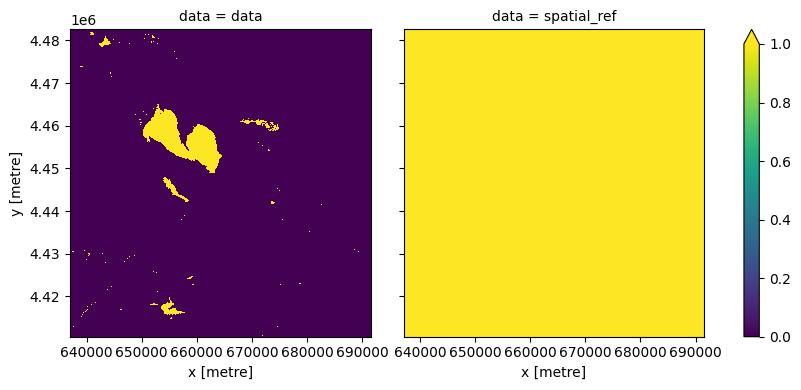

In [71]:
_ = (
    water_bodies.isel(time=3)
    .to_array("data")
    .plot.imshow(
        col="data",
        size=4,
        vmin=0,
        vmax=1,
    )
)